# 1. Introduction <a name="introduction"></a>

Dans ce Notebook, nous allons répondre à l'exercice : **Forecasting Intra-Day Prices in the GB Power Market**.  
L'objectif est de prédire le **prix intra-day (ID)** publié 2 heures avant la livraison, 
en utilisant différentes sources de données publiques (Day-Ahead Price, indicateurs de demande, etc.).

**Contexte**:
- Le marché de l'électricité en GB est très volatil.
- Nous disposons de [Data Source X, Data Source Y].
- Le dataset final contient environ XX lignes (période 2024-01-01 à 2025-02-15, etc.).

**Plan**:
1. Charger et nettoyer les données
2. Analyser (EDA)
3. Mettre en place un pipeline de modélisation (XGBoost / RandomForest)
4. Évaluer la performance (RMSE, MAE, R²)
5. Discuter des résultats et piste d'amélioration


# 2. Imports et Configuration <a name="imports-et-configuration"></a>

Ici, nous importons les librairies principales et définissons certaines option 
(pour l'affichage, le style des graphiques, etc).
.


In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
import xgboost as xgb

from io import StringIO
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

warnings.filterwarnings("ignore")

# Configuration globale
plt.style.use('seaborn-v0_8-whitegrid')
pd.options.display.max_columns = 50

# 3. Chargement des données <a name="chargement-des-données"></a>

Nous allons maintenant définir plusieurs fonctions permettant de récupérer les donnée 
depuis l'API Elexon/BMRS (demand forecast, indicated forecast, system prices. 
Ensuite, nous fusionnerons ces données en un seul DataFrame via `merge_data_for_perid`.


In [2]:
def generate_date_chunks(start_date, end_date, chunk_size_days=7):
    """
    Génère des intervalles de date (start, end) de taille maximum `chunk_size_days`.
    Utile pour appeler l'API sur de petites fenêtres (7 jours) afin d'éviter les limites.
    
    :param start_date: str, ex. "2023-02-15"
    :param end_date:   str, ex. "2025-02-15"
    :param chunk_size_days: int, ex. 7
    :return: generator of (start, end) in 'YYYY-MM-DD' format
    """
    start = pd.to_datetime(start_date)
    end   = pd.to_datetime(end_date)
    current = start
    
    while current <= end:
        chunk_end = current + pd.Timedelta(days=chunk_size_days - 1)
        if chunk_end > end:
            chunk_end = end
        yield (current.strftime("%Y-%m-%d"), chunk_end.strftime("%Y-%m-%d"))
        current = chunk_end + pd.Timedelta(days=1)

def fetch_demand_forecast_day_ahead_chunked(start_date: str, end_date: str, output_format: str = "json", boundary: str = None) -> pd.DataFrame:
    """
    Récupère la Day-Ahead Demand Forecast (NDF, TSDF) en segmentant la période en chunks de 7 jours,
    via l'endpoint /forecast/demand/day-ahead/latest
    
    :param start_date: str, date de début
    :param end_date:   str, date de fin
    :param output_format: "json" ou "csv"
    :param boundary: str, ex. "zonal" si nécessaire
    :return: pd.DataFrame concaténé de toutes les réponses
    """
    base_url = "https://data.elexon.co.uk/bmrs/api/v1/forecast/demand/day-ahead/latest"
    all_dfs = []

    for (chunk_start, chunk_end) in generate_date_chunks(start_date, end_date, 7):
        params = {
            "from": f"{chunk_start}T00:00:00Z",
            "to":   f"{chunk_end}T23:59:59Z",
            "format": output_format
        }
        if boundary:
            params["boundary"] = boundary
        
        r = requests.get(base_url, params=params)
        if r.status_code == 200:
            if output_format == "json":
                data_json = r.json()
                data = data_json.get("data", [])
                if data:
                    df_chunk = pd.DataFrame(data)
                    all_dfs.append(df_chunk)
            elif output_format == "csv":
                df_chunk = pd.read_csv(StringIO(r.text))
                if not df_chunk.empty:
                    all_dfs.append(df_chunk)
            else:
                raise ValueError("Format non géré (utiliser 'json' ou 'csv').")
        else:
            print(f"[Warning] Erreur API [{r.status_code}] sur {chunk_start} - {chunk_end}: {r.text}")

    if not all_dfs:
        return pd.DataFrame()
    
    df_final = pd.concat(all_dfs, ignore_index=True)
    return df_final

def fetch_indicated_day_ahead_evolution_range(start_date: str, end_date: str, output_format: str = "json", boundary: str = None) -> pd.DataFrame:
    """
    Récupère l'evolution indicated day-ahead forecast (INDDEM, INDGEN, IMBALNGC, MELNGC)
    via /forecast/indicated/day-ahead/evolution,
    en bouclant sur chaque jour + settlementPeriod=1..48.
    """
    base_url = "https://data.elexon.co.uk/bmrs/api/v1/forecast/indicated/day-ahead/evolution"
    sp_params = [("settlementPeriod", str(i)) for i in range(1, 49)]
    all_dfs = []
    
    date_range = pd.date_range(start_date, end_date, freq='D')
    for d in date_range:
        date_str = d.strftime("%Y-%m-%d")

        base_params = [("settlementDate", date_str), ("format", output_format)]
        params = base_params + sp_params
        
        r = requests.get(base_url, params=params)
        if r.status_code == 200:
            if output_format == "json":
                data_json = r.json()
                # On vérifie si la racine est un dict contenant "data"
                if isinstance(data_json, dict):
                    data_list = data_json.get("data", [])
                    if data_list:
                        df_chunk = pd.DataFrame(data_list)
                        all_dfs.append(df_chunk)
                else:
                    print(f"[Warning] Structure inattendue pour date={date_str}: {type(data_json)}")
            elif output_format == "csv":
                df_chunk = pd.read_csv(StringIO(r.text))
                if not df_chunk.empty:
                    all_dfs.append(df_chunk)
            else:
                raise ValueError("Format non géré (utiliser 'json' ou 'csv').")
        else:
            print(f"[Warning] Erreur API [{r.status_code}] pour date={date_str}: {r.text}")

    if not all_dfs:
        return pd.DataFrame()

    return pd.concat(all_dfs, ignore_index=True)

def fetch_system_prices_one_day(settlement_date: str, output_format: str = "json") -> pd.DataFrame:
    """
    Récupère System Price (SBP, SSP, NIV) pour 1 jour:
      GET /balancing/settlement/system-prices/{settlementDate}
    
    :param settlement_date: ex. "2025-01-01"
    :param output_format: "json" ou "csv"
    :return: pd.DataFrame
    """
    base_url = f"https://data.elexon.co.uk/bmrs/api/v1/balancing/settlement/system-prices/{settlement_date}"
    params = {"format": output_format}

    r = requests.get(base_url, params=params)
    if r.status_code == 200:
        if output_format == "json":
            data_json = r.json()
            data = data_json.get("data", [])
            df = pd.DataFrame(data)
            return df
        elif output_format == "csv":
            df = pd.read_csv(StringIO(r.text))
            return df
        else:
            raise ValueError("Format non géré (utiliser 'json' ou 'csv').")
    else:
        print(f"[Warning] Erreur API ({r.status_code}) pour {settlement_date}: {r.text}")
        return pd.DataFrame()

def fetch_system_prices_range_day_by_day(start_date: str, end_date: str, output_format="json") -> pd.DataFrame:
    """
    Boucle sur chaque journée entre start_date et end_date
    pour récupérer System Prices (SBP, SSP, NIV) via fetch_system_prices_one_day.
    """
    date_range = pd.date_range(start_date, end_date, freq='D')
    list_sp = []
    for d in date_range:
        d_str = d.strftime("%Y-%m-%d")
        df_day = fetch_system_prices_one_day(d_str, output_format=output_format)
        if not df_day.empty:
            list_sp.append(df_day)
    if list_sp:
        return pd.concat(list_sp, ignore_index=True)
    else:
        return pd.DataFrame()

### Fonctions d'agrégation (Pick Indicated Forecast T-2h) et Merge final

In [3]:
def pick_indicated_forecast_t_minus_2h(df_indicated: pd.DataFrame) -> pd.DataFrame:
    """
    Filtre df_indicated pour ne garder qu'une publication par (settlementDate, settlementPeriod, startTime):
      - On calcule T-2h = startTime - 2h
      - On garde les lignes où publishTime <= T-2h
      - Parmi elles, on prend celle dont publishTime est la plus grande (la plus récente avant T-2h)
    
    :param df_indicated: DataFrame Indicated day-ahead
    :return: DataFrame filtré
    """
    if df_indicated.empty:
        return df_indicated

    df_indicated["publishTime_utc"] = pd.to_datetime(df_indicated["publishTime"], utc=True, errors="coerce")
    df_indicated["startTime_utc"]   = pd.to_datetime(df_indicated["startTime"],   utc=True, errors="coerce")

    df_indicated["T_minus_2h"] = df_indicated["startTime_utc"] - pd.Timedelta(hours=2)

    df_filtered = df_indicated[df_indicated["publishTime_utc"] <= df_indicated["T_minus_2h"]].copy()

    if df_filtered.empty:
        return df_filtered  # aucune publication <= T-2h ?

    # Pour chaque (settlementDate, settlementPeriod, startTime_utc), on prend la publication la plus récente (publishTime_utc max)
    df_filtered.sort_values("publishTime_utc", inplace=True)
    df_unique = df_filtered.groupby(
        ["settlementDate","settlementPeriod","startTime_utc"], as_index=False
    ).tail(1)

    df_unique.drop(columns=["publishTime_utc","startTime_utc","T_minus_2h"], inplace=True, errors="ignore")

    return df_unique

def merge_data_for_period(start_date: str, end_date: str, output_format="json") -> pd.DataFrame:
    """
    Récupère et fusionne:
      - Day-Ahead Demand Forecast
      - Indicated Day-Ahead Forecast (évolution, puis filtré T-2h)
      - System Prices
    sur la période [start_date, end_date], puis renvoie un DataFrame final.

    :return: DataFrame indexé en datetime, colonnes: TSDF, NDF, INDDEM, INDGEN, IMBALNGC, SBP, etc.
    """

    # A) Demand Forecast
    df_demand = fetch_demand_forecast_day_ahead_chunked(start_date, end_date, output_format=output_format)
    # B) Indicated Day-Ahead
    df_indicated = fetch_indicated_day_ahead_evolution_range(start_date, end_date, output_format=output_format)
    # C) System Prices
    df_system_prices = fetch_system_prices_range_day_by_day(start_date, end_date, output_format=output_format)

    def to_datetime_index(df, time_col="startTime", date_col="settlementDate", period_col="settlementPeriod"):
        """
        Convertit en datetime index. 
        - Si time_col existe => parse direct
        - Sinon => reconstruit via settlementDate + settlementPeriod
        """
        if df.empty:
            return df
        if time_col in df.columns:
            df["datetime"] = pd.to_datetime(df[time_col], utc=True, errors='coerce')
        else:
            if date_col in df.columns and period_col in df.columns:
                df["datetime"] = (
                    pd.to_datetime(df[date_col]) 
                    + pd.to_timedelta((df[period_col] - 1)*30, unit='m')
                )
            else:
                df["datetime"] = pd.NaT
        return df

    df_demand       = to_datetime_index(df_demand)
    df_indicated    = to_datetime_index(df_indicated)
    df_system_prices= to_datetime_index(df_system_prices)

    # Sélectionner la publication T-2h dans df_indicated
    df_indicated = pick_indicated_forecast_t_minus_2h(df_indicated)
    
    # Datetime en index
    for df_ in [df_demand, df_indicated, df_system_prices]:
        if not df_.empty and "datetime" in df_.columns:
            df_.set_index("datetime", inplace=True)

    if not df_demand.empty:
        df_demand.rename(columns={"transmissionSystemDemand": "TSDF",
                                  "nationalDemand": "NDF"}, inplace=True)
    if not df_indicated.empty:
        df_indicated.rename(columns={"indicatedDemand":"INDDEM",
                                     "indicatedGeneration":"INDGEN",
                                     "indicatedMargin":"MELNGC",
                                     "indicatedImbalance":"IMBALNGC"}, inplace=True)
    if not df_system_prices.empty:
        df_system_prices.rename(columns={"systemBuyPrice":"SBP",
                                         "systemSellPrice":"SSP",
                                         "netImbalanceVolume":"NIV"}, inplace=True)

    df_merge_1 = pd.merge(df_demand, df_indicated, how='outer', left_index=True, right_index=True, suffixes=("_dem","_ind"))
    df_final = pd.merge(df_merge_1, df_system_prices, how='outer', left_index=True, right_index=True, suffixes=("_m1","_m2"))

    df_final.sort_index(inplace=True)

    cols_to_drop = ["settlementDate_dem", "settlementPeriod_dem", "boundary_dem",
                    "publishTime_dem", "startTime_dem",
                    "settlementDate_ind", "settlementPeriod_ind", "boundary_ind",
                    "publishTime_ind", "startTime_ind"]
    df_final.drop(columns=cols_to_drop, inplace=True, errors="ignore")

    df_final.rename(columns={"settlementDate": "settlementDate_sys",
                             "settlementPeriod": "settlementPeriod_sys",
                             "startTime": "startTime_sys"}, inplace=True)
    
    # Supprime boundary comme c'est toujours 'N' (pour National), ne traite pas de zonal/locational pour le moment
    df_final.drop(columns=["boundary_dem", "boundary_ind"], inplace=True, errors="ignore")

    return df_final

### Exemple d'appel pour récupérer les données sur la période souhaitée

In [4]:
start_date = "2023-02-15"
end_date   = "2025-02-15"

df = merge_data_for_period(start_date, end_date, output_format="json")
df

,TSDF,NDF,INDGEN,INDDEM,MELNGC,IMBALNGC,settlementDate_sys,settlementPeriod_sys,startTime_sys,createdDateTime,SSP,SBP,bsadDefaulted,priceDerivationCode,reserveScarcityPrice,NIV,sellPriceAdjustment,buyPriceAdjustment,replacementPrice,replacementPriceReferenceVolume,totalAcceptedOfferVolume,totalAcceptedBidVolume,totalAdjustmentSellVolume,totalAdjustmentBuyVolume,totalSystemTaggedAcceptedOfferVolume,totalSystemTaggedAcceptedBidVolume,totalSystemTaggedAdjustmentSellVolume,totalSystemTaggedAdjustmentBuyVolume
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-02-15 00:00:00+00:00,24750,24150.0,24988.0,-17794.0,35134.0,237.0,2023-02-15,1.0,2023-02-15T00:00:00Z,2023-02-15T00:52:24Z,106.51,106.51,False,N,NaN,-47.614500,0.0,0.0,NaN,NaN,596.520800,-644.072800,0.0,0.000,596.520800,-643.072800,0.0,0.000
2023-02-15 00:30:00+00:00,25153,24500.0,25516.0,-17989.0,35102.0,363.0,2023-02-15,2.0,2023-02-15T00:30:00Z,2023-02-15T01:22:30Z,166.90,166.90,False,P,NaN,128.409800,0.0,0.0,NaN,NaN,594.388000,-478.642900,0.0,12.667,593.388000,-478.642900,0.0,12.667
2023-02-15 01:00:00+00:00,26010,24419.0,26124.0,-18800.0,34669.0,41.0,2023-02-15,3.0,2023-02-15T01:00:00Z,2023-02-15T01:52:19Z,165.00,165.00,False,P,NaN,11.658000,0.0,0.0,NaN,NaN,502.512800,-490.842000,0.0,0.000,501.512800,-490.842000,0.0,0.000
2023-02-15 01:30:00+00:00,25502,23649.0,26401.0,-18658.0,35114.0,578.0,2023-02-15,4.0,2023-02-15T01:30:00Z,2023-02-15T02:22:22Z,98.00,98.00,False,N,NaN,-83.605410,0.0,0.0,NaN,NaN,502.500000,-586.105400,0.0,0.000,502.500000,-585.105400,0.0,0.000
2023-02-15 02:00:00+00:00,25178,23333.0,25660.0,-18385.0,34642.0,212.0,2023-02-15,5.0,2023-02-15T02:00:00Z,2023-02-15T02:52:23Z,97.20,97.20,False,N,NaN,-262.207580,0.0,0.0,NaN,NaN,581.108900,-843.316500,0.0,0.000,581.108900,-842.316500,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-15 21:30:00+00:00,33274,32369.0,34692.0,-19063.0,35605.0,1962.0,2025-02-15,44.0,2025-02-15T21:30:00Z,2025-02-16T22:14:36Z,91.00,91.00,False,N,0.0,-79.936667,0.0,0.0,91.0,1.0,368.850000,-448.561667,0.0,0.000,368.850000,-447.561667,None,NaN
2025-02-15 22:00:00+00:00,31403,30633.0,32473.0,-18179.0,36531.0,1390.0,2025-02-15,45.0,2025-02-15T22:00:00Z,2025-02-16T22:44:35Z,129.00,129.00,False,P,0.0,156.408877,0.0,0.0,NaN,NaN,469.284473,-312.533548,0.0,0.000,468.284473,-312.533548,None,NaN
2025-02-15 22:30:00+00:00,29840,28867.0,29910.0,-17655.0,37998.0,254.0,2025-02-15,46.0,2025-02-15T22:30:00Z,2025-02-16T23:14:32Z,129.00,129.00,False,P,0.0,243.024979,0.0,0.0,NaN,NaN,490.775721,-301.442195,0.0,54.224,489.775721,-301.442195,None,54.224


In [5]:
df.to_csv("df.csv")

# 4. Exploratory Data Analysis (EDA) <a name="exploratory-data-analysis-eda"></a>

Dans cette section, nous explorons la distribution des principales variables:
- **SBP** (System Buy Price, l’objectif de prédiction)
- **TSDF**, **NDF** (Demand Forecasts)
- **INDDEM**, **MELNGC**, **IMBALNGC** (Indicated Demand, Margin, Imbalance)
- etc.

**Objectifs**:
1. Détecter les valeurs manquantes,
2. Comprendre la répartition (histogrammes), détecter les pics extrêmes,
3. Analyser les corrélations,
4. Observer l’évolution temporellede **SBP**.


In [6]:
# Aperçu des colonnes
print("Liste des colonnes du DataFrame:")
print(df.columns)

print("\nValeurs manquantes par colonne:")
missing_counts = df.isnull().sum()
print(missing_counts)

# Petit commentaire sur la proportion de NaN
n_total = len(df)
missing_info = (missing_counts / n_total * 100).sort_values(ascending=False)
print("\nPourcentage de NaN (top 10):")
print(missing_info.head(10))

Liste des colonnes du DataFrame:
Index(['TSDF', 'NDF', 'INDGEN', 'INDDEM', 'MELNGC', 'IMBALNGC',
       'settlementDate_sys', 'settlementPeriod_sys', 'startTime_sys',
       'createdDateTime', 'SSP', 'SBP', 'bsadDefaulted', 'priceDerivationCode',
       'reserveScarcityPrice', 'NIV', 'sellPriceAdjustment',
       'buyPriceAdjustment', 'replacementPrice',
       'replacementPriceReferenceVolume', 'totalAcceptedOfferVolume',
       'totalAcceptedBidVolume', 'totalAdjustmentSellVolume',
       'totalAdjustmentBuyVolume', 'totalSystemTaggedAcceptedOfferVolume',
       'totalSystemTaggedAcceptedBidVolume',
       'totalSystemTaggedAdjustmentSellVolume',
       'totalSystemTaggedAdjustmentBuyVolume'],
      dtype='object')

Valeurs manquantes par colonne:
TSDF                                         0
NDF                                        282
INDGEN                                       4
INDDEM                                     172
MELNGC                                     747
IMBAL

Observation : On constate par exemple que `replacementPrice` et `replacementPriceReferenceVolume` sont massivement vides (près de ~85 %). Nous déciderons plus tard de les supprimer ou imputer selon leur pertinence.

In [7]:
print("=== df.describe() ===")
display(df.describe())

print("\n=== df.info() ===")
print(df.info())

=== df.describe() ===


,TSDF,NDF,INDGEN,INDDEM,MELNGC,IMBALNGC,settlementPeriod_sys,SSP,SBP,reserveScarcityPrice,NIV,sellPriceAdjustment,buyPriceAdjustment,totalAcceptedOfferVolume,totalAcceptedBidVolume,totalAdjustmentSellVolume,totalAdjustmentBuyVolume,totalSystemTaggedAcceptedOfferVolume,totalSystemTaggedAcceptedBidVolume,totalSystemTaggedAdjustmentBuyVolume
count,35197.000000,34915.000000,35193.000000,35025.000000,34450.000000,34363.000000,35195.000000,35195.000000,35195.000000,25804.000000,35195.000000,35195.0,35195.000000,35195.000000,35195.000000,35195.000000,35195.000000,35190.000000,35190.000000,28121.000000
mean,28291.095917,26327.855707,28925.639417,-18752.992320,29937.739565,644.156622,24.509362,81.875111,81.875111,0.502197,-24.508101,0.0,0.032593,676.714696,-739.114287,-112.530678,150.413750,676.423240,-738.767890,188.149279
std,5873.269632,6125.982657,5907.367760,4197.929009,5147.476772,1030.850794,13.843442,68.073848,68.073848,17.489131,304.571961,0.0,0.528529,576.686137,625.760534,305.027982,241.837313,576.599844,625.638869,256.938624
min,16892.000000,13880.000000,14730.000000,-39639.000000,12275.000000,-5120.000000,1.000000,-185.330000,-185.330000,0.000000,-1869.258500,0.0,0.000000,0.000000,-4047.642097,-2750.000000,0.000000,0.000000,-4046.642097,0.000000
25%,23862.000000,21600.000000,24667.000000,-20848.000000,26131.250000,1.000000,13.000000,53.500000,53.500000,0.000000,-192.635765,0.0,0.000000,238.000004,-1062.145833,-8.800000,0.000000,238.000000,-1061.757208,0.000000
50%,27184.000000,25400.000000,27898.000000,-18097.000000,29985.500000,655.000000,25.000000,81.700000,81.700000,0.000000,-11.634325,0.0,0.000000,502.666667,-567.038200,0.000000,29.750000,502.304250,-566.547281,92.809000
75%,31863.000000,30208.500000,32443.000000,-15760.000000,33810.750000,1302.000000,36.000000,112.605000,112.605000,0.000000,146.381650,0.0,0.000000,990.626687,-264.735250,0.000000,230.709500,990.052083,-264.525687,277.222542
max,47884.000000,45538.000000,49907.000000,-10614.000000,44918.000000,10527.000000,50.000000,2900.000000,2900.000000,2088.159600,1733.556300,0.0,13.710000,4164.004400,0.000000,0.000000,3100.000000,4163.004400,0.000000,3099.000000



=== df.info() ===
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35197 entries, 2023-02-15 00:00:00+00:00 to 2025-02-15 23:30:00+00:00
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   TSDF                                   35197 non-null  int64  
 1   NDF                                    34915 non-null  float64
 2   INDGEN                                 35193 non-null  float64
 3   INDDEM                                 35025 non-null  float64
 4   MELNGC                                 34450 non-null  float64
 5   IMBALNGC                               34363 non-null  float64
 6   settlementDate_sys                     35195 non-null  object 
 7   settlementPeriod_sys                   35195 non-null  float64
 8   startTime_sys                          35195 non-null  object 
 9   createdDateTime                        35195 non-null  object 
 10  SSP 

- On voit que la moyenne de `SBP` est ~ 80–90, avec un min à -185 et un max à 2900 (valeurs extrêmes).
- Les colonnes `TSDF`, `NDF` etc. vont de ~16 000 à ~47 000.

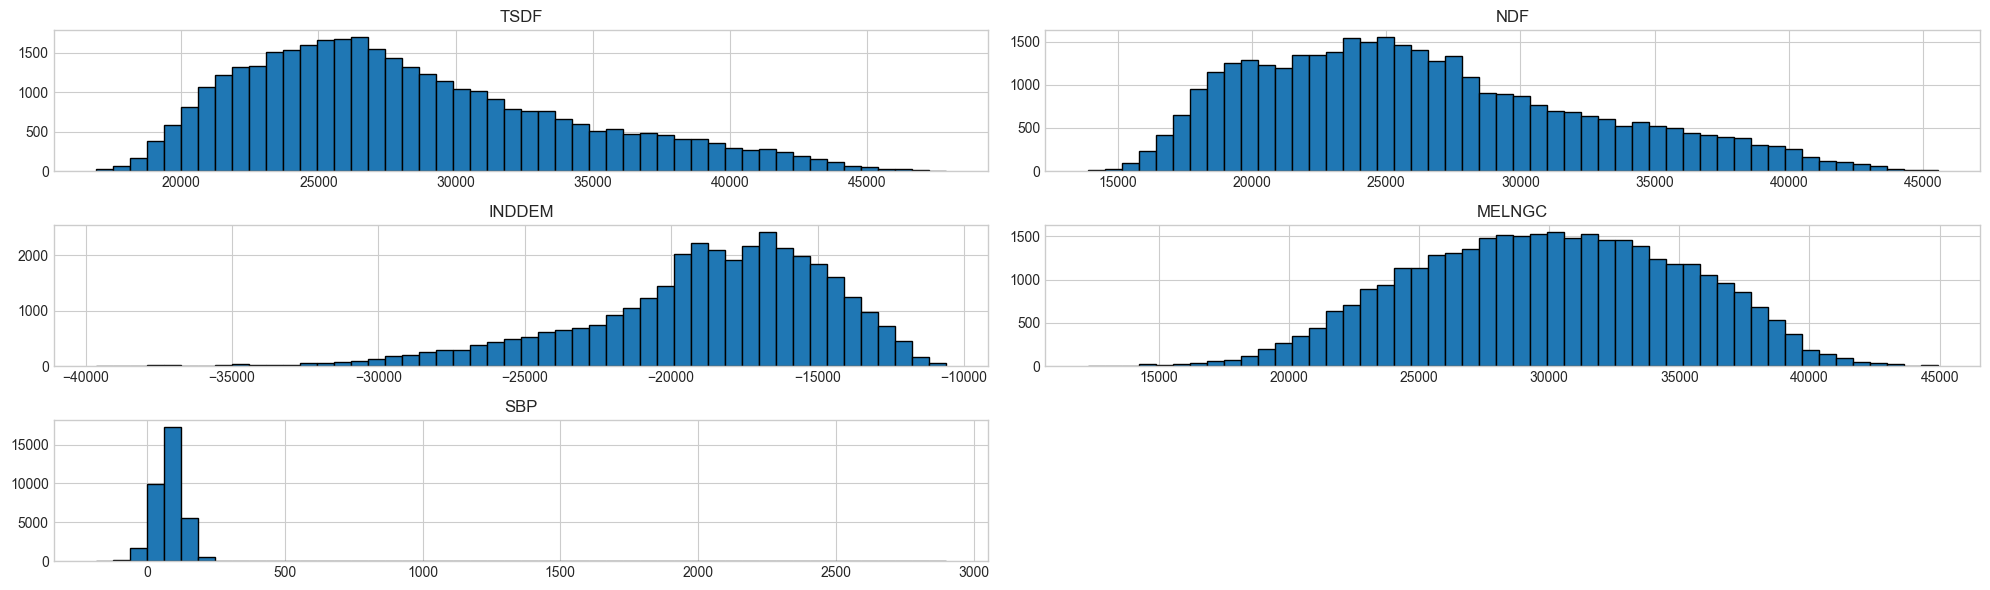

In [8]:
cols_to_plot = ["TSDF","NDF","INDDEM","MELNGC","SBP"]
df[cols_to_plot].hist(figsize=(20,6), bins=50, edgecolor="black")
plt.tight_layout()
plt.show()

- TSDF/NDF : centrées autour de 25–30k.
- INDDEM : peut être négatif (jusqu’à -30 000).
- SBP : majoritairement entre 0 et 200, mais avec des pics allant jusqu’à 2900.

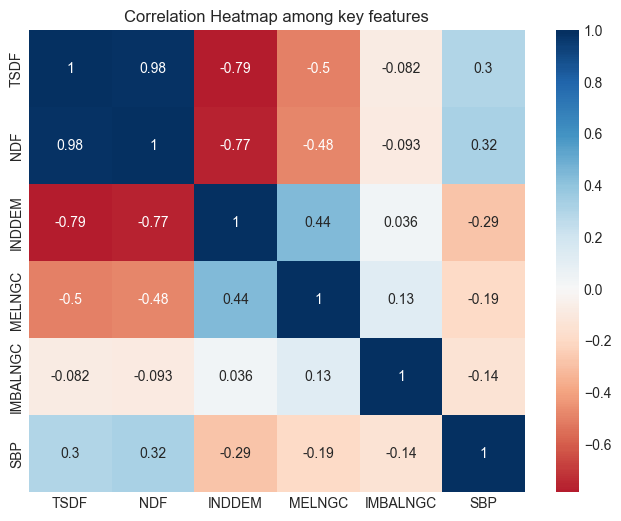

In [9]:
corr_cols = ["TSDF","NDF","INDDEM","MELNGC","IMBALNGC","SBP"]
corr = df[corr_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="RdBu", center=0)
plt.title("Correlation Heatmap among key features")
plt.show()

- TSDF et NDF sont très corrélés (0.98).
- INDDEM est fortement négatif avec TSDF/NDF (~ -0.9).
- SBP a une corrélation modérée (~0.2) avec TSDF/NDF.
- Cela suggère que la demande n’explique qu’une partie du prix, d’où l’intérêt d’autres variables (IMBALNGC, etc.).

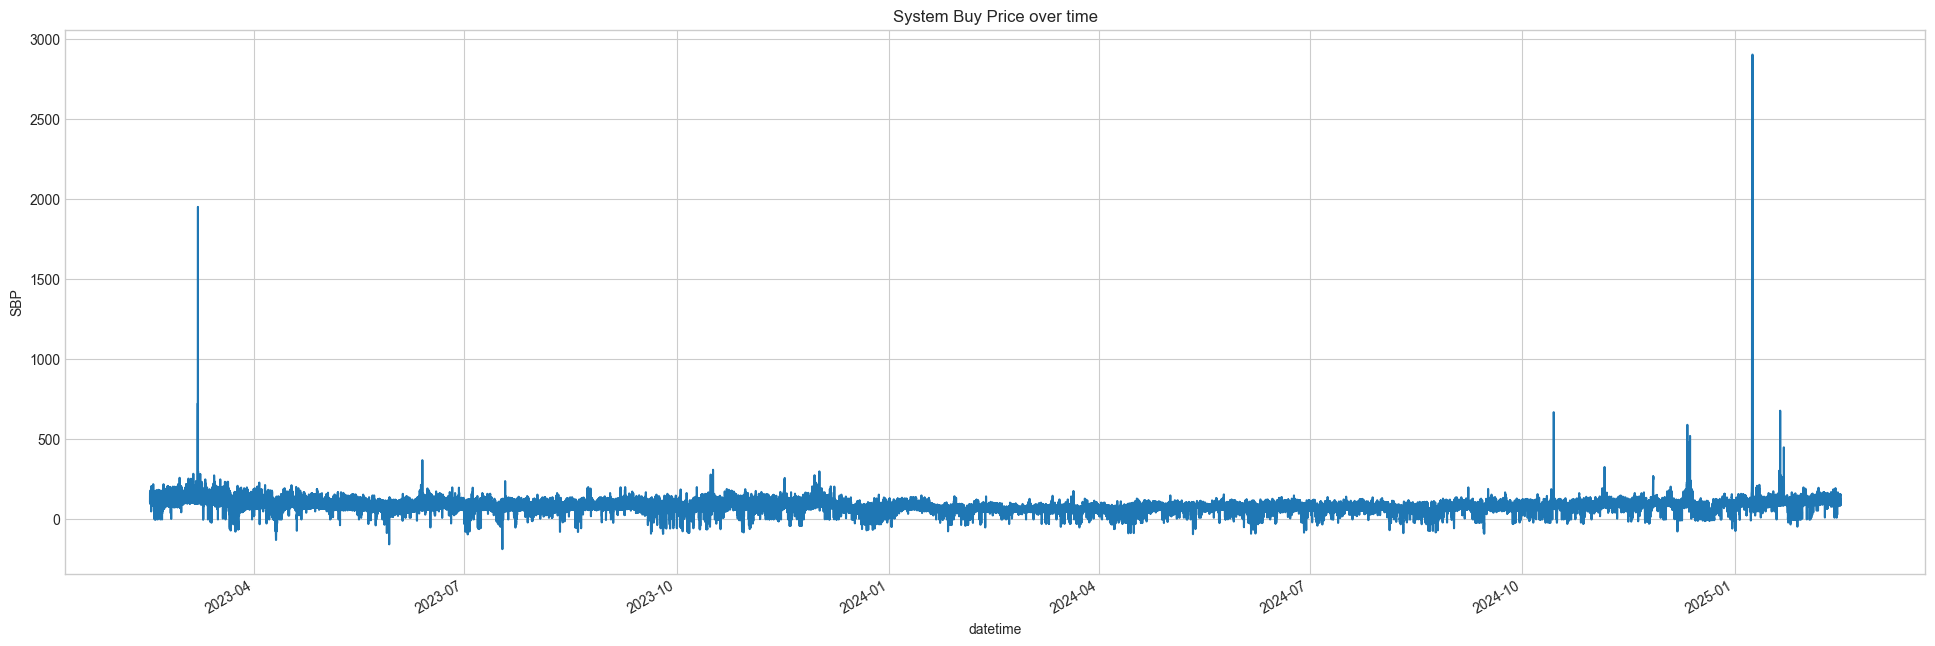

In [10]:
plt.figure(figsize=(24,8))
df["SBP"].plot()
plt.title("System Buy Price over time")
plt.xlabel("datetime")
plt.ylabel("SBP")
plt.show()

On observe plusieurs pics importants, notamment vers ~2 900. On note aussi quelques valeurs négatives. Cela indique une forte volatilité du marché.

### Analyse spécifique de certaines colonnes
Par exemple, nous examinons les colonnes massivement vides ou potentiellement utiles:
- `reserveScarcityPrice`
- `replacementPrice`
- `replacementPriceReferenceVolume`
- `totalSystemTaggedAdjustmentSellVolume`
- `totalSystemTaggedAdjustmentBuyVolume`

In [11]:
def analyze_column(df: pd.DataFrame, col_name: str, sbp_col: str = "SBP"):
    """
    Analyse de base pour une colonne donnée:
      1) Nombre de NaN et proportion
      2) Stats descriptives des valeurs non-nulles
      3) Histogramme (si numérique)
      4) Scatterplot (col_name vs SBP) si numérique
    """
    n_rows = len(df)
    n_nan = df[col_name].isna().sum()
    frac_nan = n_nan / n_rows * 100
    
    print(f"=== Analyse for column: {col_name} ===")
    print(f"Total rows: {n_rows}, NaN count: {n_nan} ({frac_nan:.2f}%)")
    
    # Stats descriptives (sur valeurs non-nulles)
    non_null_data = df[col_name].dropna()
    if not non_null_data.empty and pd.api.types.is_numeric_dtype(non_null_data):
        print("\nDescriptive stats for non-null values:")
        print(non_null_data.describe())
    else:
        print("\nNon-numeric or empty. Skipping descriptive stats.")
    
    plt.figure(figsize=(12,4))
    non_null_data.hist(bins=50, edgecolor="black")
    plt.title(f"Histogram of {col_name} (non-null values)")
    plt.xlabel(col_name)
    plt.ylabel("Frequency")
    plt.show()

    # Relation avec SBP (scatter)
    if sbp_col in df.columns and pd.api.types.is_numeric_dtype(df[sbp_col]):
        plt.figure(figsize=(12,4))
        df_plot = df.dropna(subset=[col_name, sbp_col])
        plt.scatter(df_plot[col_name], df_plot[sbp_col], alpha=0.3)
        plt.title(f"{col_name} vs {sbp_col}")
        plt.xlabel(col_name)
        plt.ylabel(sbp_col)
        plt.show()
    
    print("\n" + "="*40 + "\n")

=== Analyse for column: reserveScarcityPrice ===
Total rows: 35197, NaN count: 9393 (26.69%)

Descriptive stats for non-null values:
count    25804.000000
mean         0.502197
std         17.489131
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2088.159600
Name: reserveScarcityPrice, dtype: float64


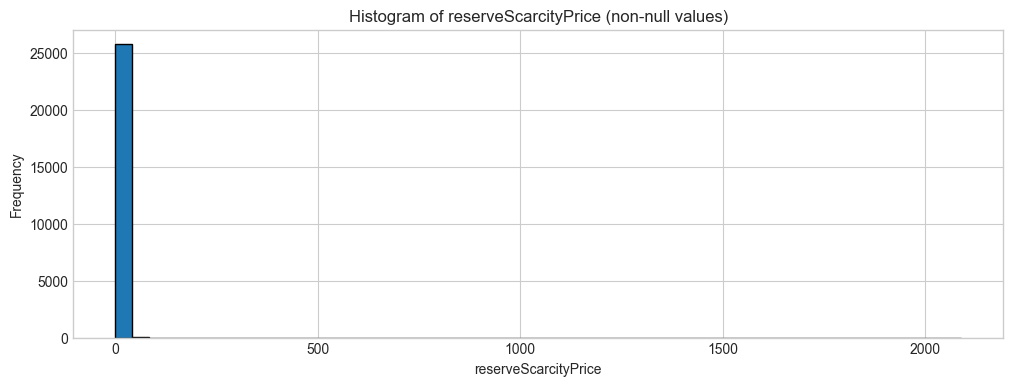

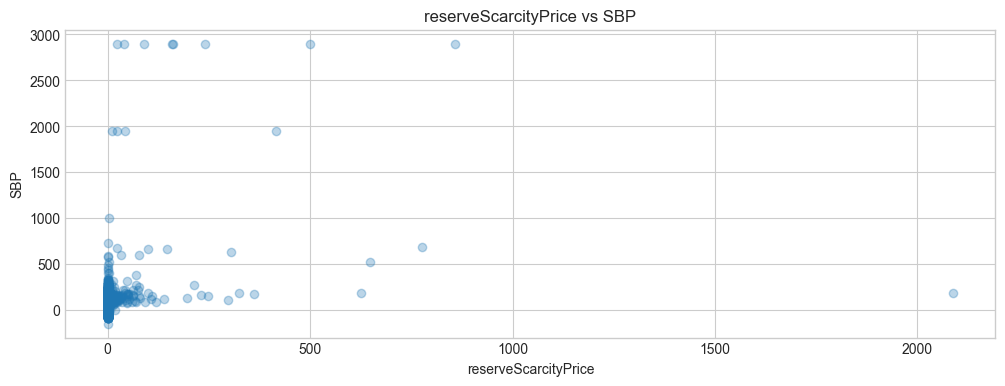



=== Analyse for column: replacementPrice ===
Total rows: 35197, NaN count: 28996 (82.38%)

Non-numeric or empty. Skipping descriptive stats.


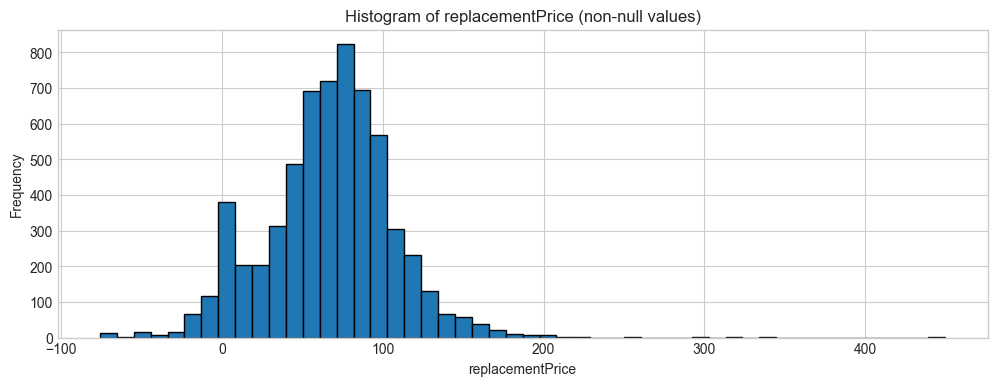

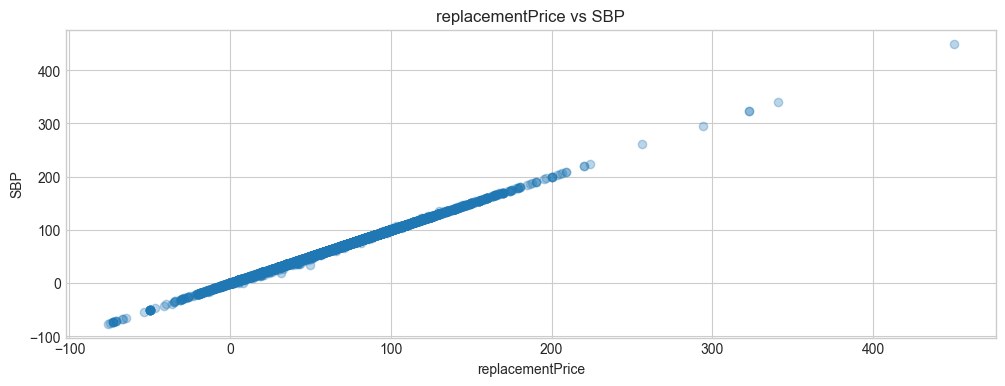



=== Analyse for column: replacementPriceReferenceVolume ===
Total rows: 35197, NaN count: 28996 (82.38%)

Non-numeric or empty. Skipping descriptive stats.


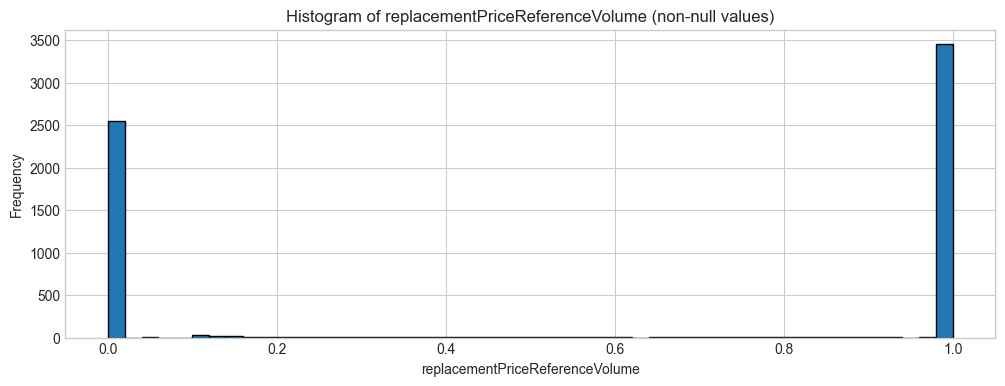

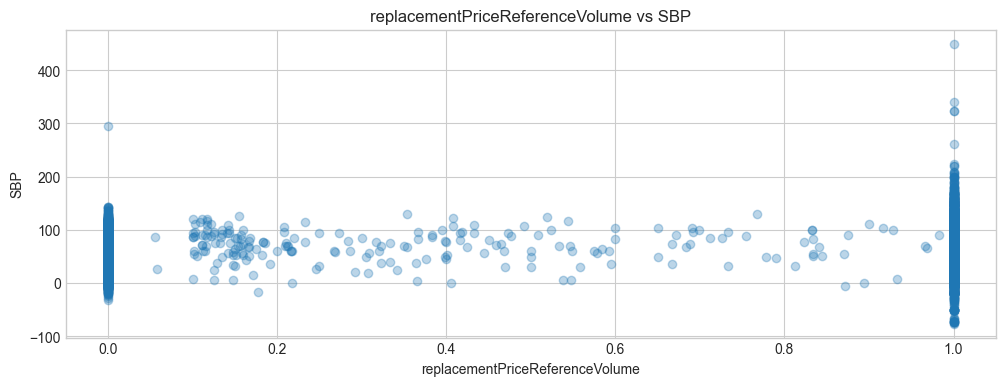



=== Analyse for column: totalSystemTaggedAdjustmentSellVolume ===
Total rows: 35197, NaN count: 13155 (37.38%)

Non-numeric or empty. Skipping descriptive stats.


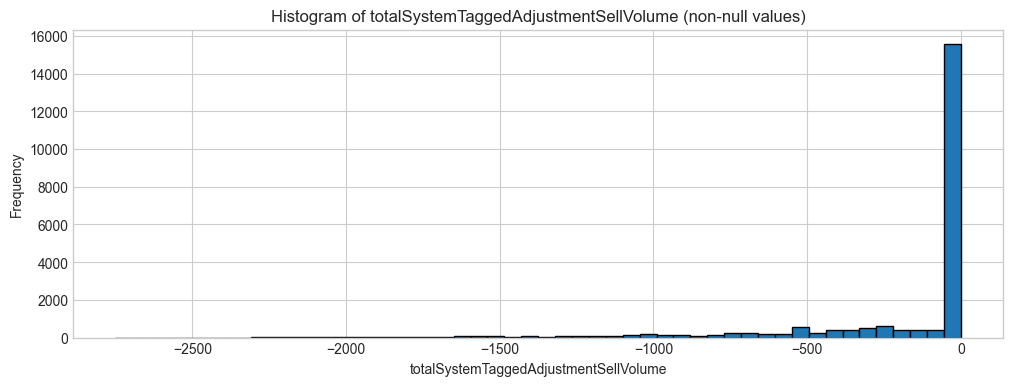

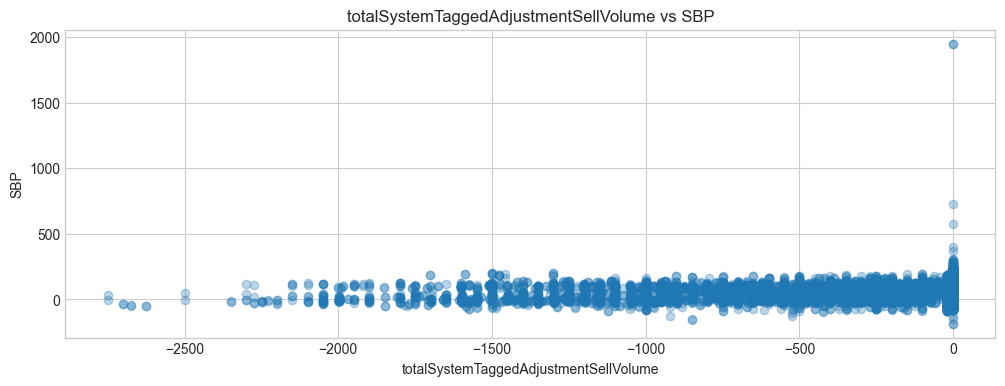



=== Analyse for column: totalSystemTaggedAdjustmentBuyVolume ===
Total rows: 35197, NaN count: 7076 (20.10%)

Descriptive stats for non-null values:
count    28121.000000
mean       188.149279
std        256.938624
min          0.000000
25%          0.000000
50%         92.809000
75%        277.222542
max       3099.000000
Name: totalSystemTaggedAdjustmentBuyVolume, dtype: float64


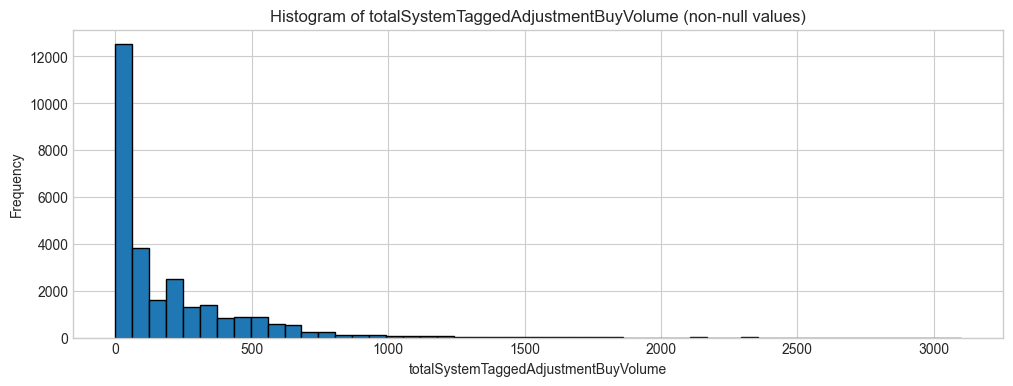

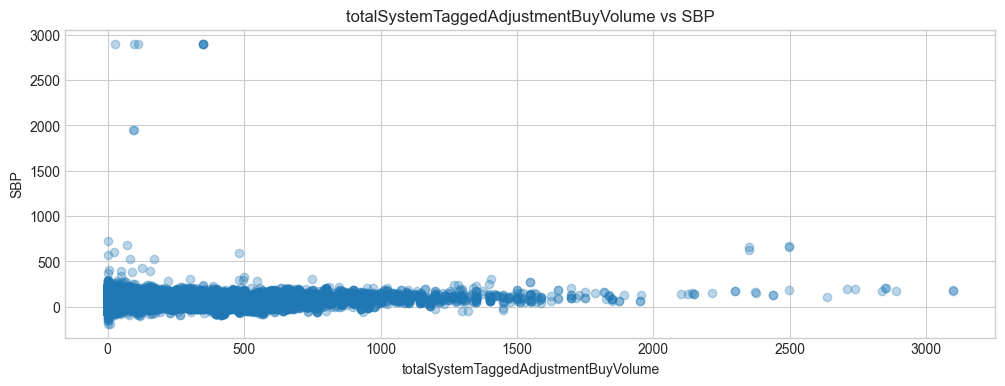

In [12]:
cols_to_analyze = ["reserveScarcityPrice", "replacementPrice", "replacementPriceReferenceVolume", "totalSystemTaggedAdjustmentSellVolume", "totalSystemTaggedAdjustmentBuyVolume"]

for col in cols_to_analyze:
    analyze_column(df, col_name=col, sbp_col="SBP")

**1. `reserveScarcityPrice`**  
- Majoritairement à 0, quelques pics rares.  
- ~27 % de valeurs manquantes.  
- Légère corrélation avec certains pics de SBP.  
- **Décision** : Conserver et imputer les NaN par 0.

**2. `replacementPrice`**  
- Distribution ~0–200, corrélation marquée avec SBP sur la portion non-nulle.  
- ~82 % de NaN => très peu de données exploitables.  
- **Décision** : Supprimer (trop de valeurs manquantes).

**3. `replacementPriceReferenceVolume`**  
- Souvent 0 ou 1, faible corrélation avec SBP.  
- ~82 % de NaN, même souci que `replacementPrice`.  
- **Décision** : Supprimer.

**4. `totalSystemTaggedAdjustmentSellVolume`**  
- Large éventail (négatif/positif), ~36 % de NaN.  
- Pas de relation nette avec SBP.  
- **Décision** : Supprimer (imputation incertaine).

**5. `totalSystemTaggedAdjustmentBuyVolume`**  
- ~20 % de NaN, valeurs surtout <500, corrélation faible.  
- **Décision** : Possibilité d’imputer à 0, mais on préfère supprimer.

**En résumé** : On **conserve** `reserveScarcityPrice` (avec imputation 0) et on **supprime** les autres colonnes.

## 5. Nettoyage et Préparation des Données <a name="nettoyage-et-préparation-des-données"></a>

Dans cette section, nous appliquons les règles de nettoyage et de préparation identifiées lors de l’EDA :

1. **Gérer les valeurs manquantes** pour les colonnes essentielles (SBP, NDF, INDDEM, MELNGC, etc.).
2. **Ajouter** des features temporelles (heure, jour de la semaine, mois).
3. **Nettoyer** ou **supprimer** les colonnes massivement vides (replacementPrice, etc.).
4. **Imputer** certaines colonnes (ex. reserveScarcityPrice à 0).
5. **Vérifier** et décider du traitement des SBP négatifs (ici, on les conserve)

In [13]:
def handle_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Supprime les lignes où certaines colonnes clés sont NaN.
    Les colonnes jugées essentielles sont : 
      - 'SBP', 'NDF', 'INDDEM', 'MELNGC', 'IMBALNGC', 
      - 'totalSystemTaggedAcceptedOfferVolume', 'totalSystemTaggedAcceptedBidVolume'.

    Retourne le DataFrame filtré.
    """
    required_cols = [
        "SBP", "NDF", "INDDEM", "MELNGC", "IMBALNGC",
        "totalSystemTaggedAcceptedOfferVolume", 
        "totalSystemTaggedAcceptedBidVolume"
    ]
    df = df.dropna(subset=required_cols)
    return df

def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ajoute des features temporelles (hour, dayofweek, month)
    basées sur l'index Datetime.
    """
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.dayofweek
    df["month"] = df.index.month
    return df

def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Pipeline simple de préprocessing :
      1) handle_missing_values : supprime les lignes 
         avec NaN sur colonnes clés.
      2) add_time_features : ajoute hour, dayofweek, month.
    """
    df = handle_missing_values(df)
    df = add_time_features(df)
    return df

In [14]:
df = preprocess_data(df)

In [15]:
def clean_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Nettoyage spécifique des colonnes identifiées comme 
    massivement vides ou nécessitant une imputation :
      - reserveScarcityPrice => imputation 0
      - replacementPrice => drop
      - replacementPriceReferenceVolume => drop
      - totalSystemTaggedAdjustmentSellVolume => drop
      - totalSystemTaggedAdjustmentBuyVolume => drop

    Retourne le DataFrame nettoyé.
    """
    
    # Imputation reserveScarcityPrice
    if "reserveScarcityPrice" in df.columns:
        df["reserveScarcityPrice"].fillna(0, inplace=True)
        print("[Info] reserveScarcityPrice: NaN -> 0.")
    else:
        print("[Warning] reserveScarcityPrice not in df.")
    
    # Suppression replacementPrice
    if "replacementPrice" in df.columns:
        df.drop(columns=["replacementPrice"], inplace=True)
        print("[Info] replacementPrice dropped (massively missing).")
    else:
        print("[Warning] replacementPrice not in df.")
    
    # Suppression replacementPriceReferenceVolume
    if "replacementPriceReferenceVolume" in df.columns:
        df.drop(columns=["replacementPriceReferenceVolume"], inplace=True)
        print("[Info] replacementPriceReferenceVolume dropped (massively missing).")
    else:
        print("[Warning] replacementPriceReferenceVolume not in df.")
    
    # Suppression totalSystemTaggedAdjustmentSellVolume
    if "totalSystemTaggedAdjustmentSellVolume" in df.columns:
        df.drop(columns=["totalSystemTaggedAdjustmentSellVolume"], inplace=True)
        print("[Info] totalSystemTaggedAdjustmentSellVolume dropped (~36% missing).")
    else:
        print("[Warning] totalSystemTaggedAdjustmentSellVolume not in df.")
    
    # Suppression totalSystemTaggedAdjustmentBuyVolume
    if "totalSystemTaggedAdjustmentBuyVolume" in df.columns:
        df.drop(columns=["totalSystemTaggedAdjustmentBuyVolume"], inplace=True)
        print("[Info] totalSystemTaggedAdjustmentBuyVolume dropped (~20% missing).")
    else:
        print("[Warning] totalSystemTaggedAdjustmentBuyVolume not in df.")
    
    return df

In [16]:
df = clean_columns(df)

[Info] reserveScarcityPrice: NaN -> 0.
[Info] replacementPrice dropped (massively missing).
[Info] replacementPriceReferenceVolume dropped (massively missing).
[Info] totalSystemTaggedAdjustmentSellVolume dropped (~36% missing).
[Info] totalSystemTaggedAdjustmentBuyVolume dropped (~20% missing).


#### Pourquoi y a-t-il des SBP négatifs et que faire ?

In [17]:
def check_negative_sbp(df: pd.DataFrame, sbp_col: str = "SBP"):
    """
    Vérifie la proportion de SBP < 0 et affiche
    quelques stats descriptives si présent.
    """
    neg_count = (df[sbp_col] < 0).sum()
    total = len(df)
    if neg_count > 0:
        print(f"[check_negative_sbp] Found {neg_count} negative SBP values out of {total} "
              f"({100*neg_count/total:.2f}%).")
        print(df.loc[df[sbp_col] < 0, sbp_col].describe())
    else:
        print("[check_negative_sbp] No negative SBP found.")

In [18]:
check_negative_sbp(df)

[check_negative_sbp] Found 1803 negative SBP values out of 33927 (5.31%).
count    1803.000000
mean      -24.449431
std        22.721935
min      -185.330000
25%       -29.560000
50%       -19.190000
75%        -8.025110
max        -0.080000
Name: SBP, dtype: float64


In [19]:
df_negative_sbp = df[df["SBP"] < 0][["settlementDate_sys", "settlementPeriod_sys", "TSDF", "NDF", "INDDEM", "MELNGC", "IMBALNGC", "hour", "dayofweek", "month", "reserveScarcityPrice", "SBP"]]

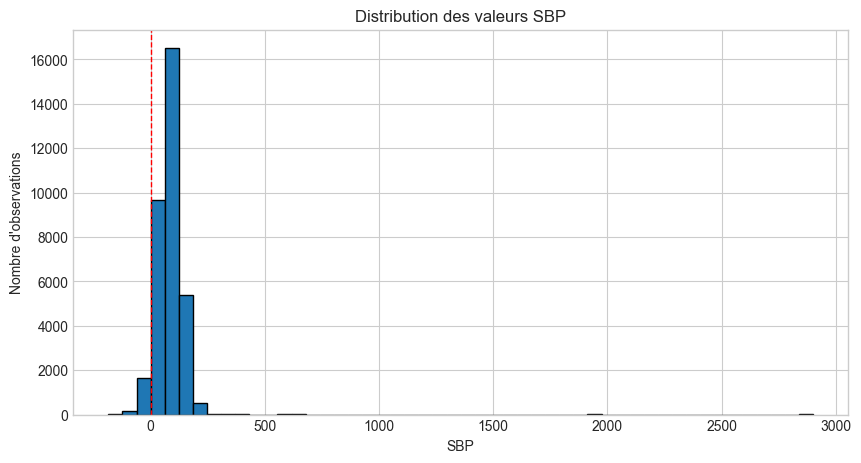

In [20]:
plt.figure(figsize=(10, 5))
df["SBP"].hist(bins=50, edgecolor="black")
plt.axvline(0, color="red", linestyle="dashed", linewidth=1) # Ligne rouge à zéro
plt.title("Distribution des valeurs SBP")
plt.xlabel("SBP")
plt.ylabel("Nombre d'observations")
plt.show()

- La plupart des valeurs sont entre 0 et 200, quelques pics > 1 000.
- ~5 % en dessous de 0, jusqu’à -185.

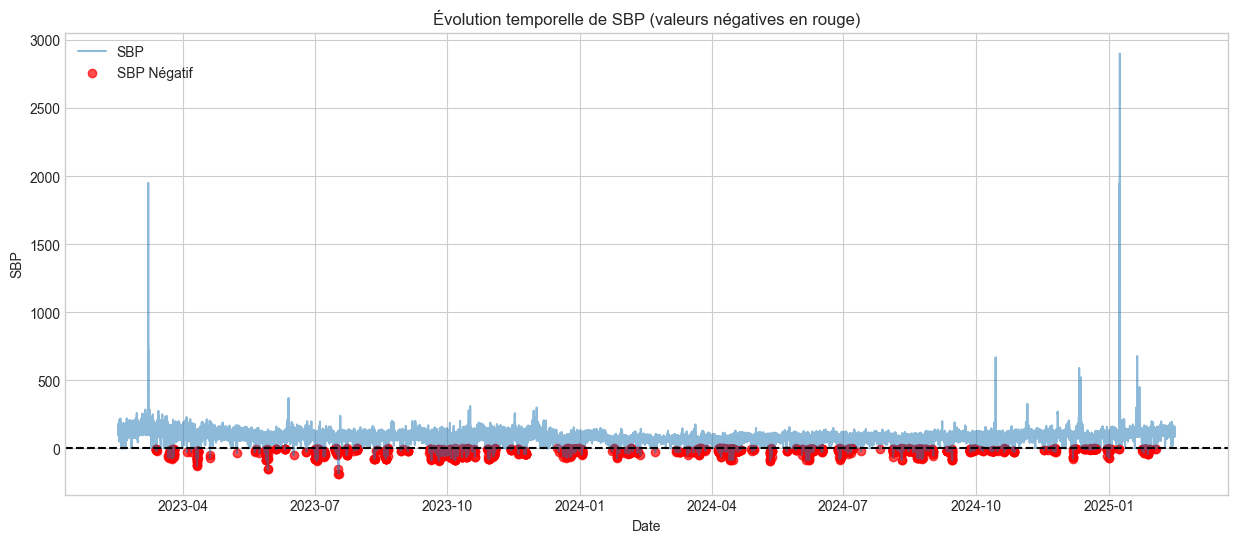

In [21]:
df["SBP_negative"] = df["SBP"] < 0
df_neg = df[df["SBP_negative"]]

plt.figure(figsize=(15, 6))
plt.plot(df.index, df["SBP"], label="SBP", alpha=0.5)
plt.scatter(df_neg.index, df_neg["SBP"], color="red", label="SBP Négatif", alpha=0.7)
plt.axhline(0, color="black", linestyle="dashed")
plt.title("Évolution temporelle de SBP (valeurs négatives en rouge)")
plt.xlabel("Date")
plt.ylabel("SBP")
plt.legend()
plt.show()

- Les SBP négatifs se répartissent dans toute la période,
- Les pics extrêmes (jusqu’à 2 900) sont rares et ponctuels,
- Indique un marché potentiellement en surplus lors de ces phases négatives.

In [22]:
df_negative_sbp.describe()

,settlementPeriod_sys,TSDF,NDF,INDDEM,MELNGC,IMBALNGC,hour,dayofweek,month,reserveScarcityPrice,SBP
count,1803.000000,1803.000000,1803.000000,1803.000000,1803.000000,1803.000000,1803.000000,1803.000000,1803.000000,1803.0,1803.000000
mean,19.252357,23707.882973,20451.159179,-16872.136439,32113.645591,1015.747643,8.740433,3.796450,7.250139,0.0,-24.449431
std,12.582253,3000.849828,3659.610721,2655.638517,4324.609774,1238.192830,6.471509,2.053164,3.111700,0.0,22.721935
min,1.000000,16892.000000,13880.000000,-32244.000000,20630.000000,-3561.000000,0.000000,0.000000,1.000000,0.0,-185.330000
25%,8.000000,21639.000000,17743.000000,-17774.000000,29068.500000,322.500000,3.000000,2.000000,4.000000,0.0,-29.560000
50%,18.000000,23540.000000,19732.000000,-16484.000000,32790.000000,1121.000000,8.000000,4.000000,7.000000,0.0,-19.190000
75%,28.000000,25202.000000,22300.000000,-15329.000000,35168.000000,1808.000000,13.000000,6.000000,10.000000,0.0,-8.025110
max,48.000000,37280.000000,35770.000000,-11920.000000,42631.000000,5557.000000,23.000000,6.000000,12.000000,0.0,-0.080000


- IMBALNGC moyen = 1015.75 (ce qui est relativement élevé, indiquant souvent un surplus d’énergie).
- MELNGC ~ 32 113 en moyenne (plutôt élevé également).
- INDDEM ~ -16 872, indiquant possiblement un solde net (ou un “négatif” signifiant un excès de production vs. consommation).
- IMBALNGC > 0 indique souvent un excès d’énergie ; on peut faire l’hypothèse qu’un SBP négatif survient quand le système est sur-approvisionné.

Les indicateurs (IMBALNGC, INDDEM) laissent penser qu’on a un surplus d’énergie lors de ces périodes. Les valeurs ne sont pas marginales (jusqu’à -185).

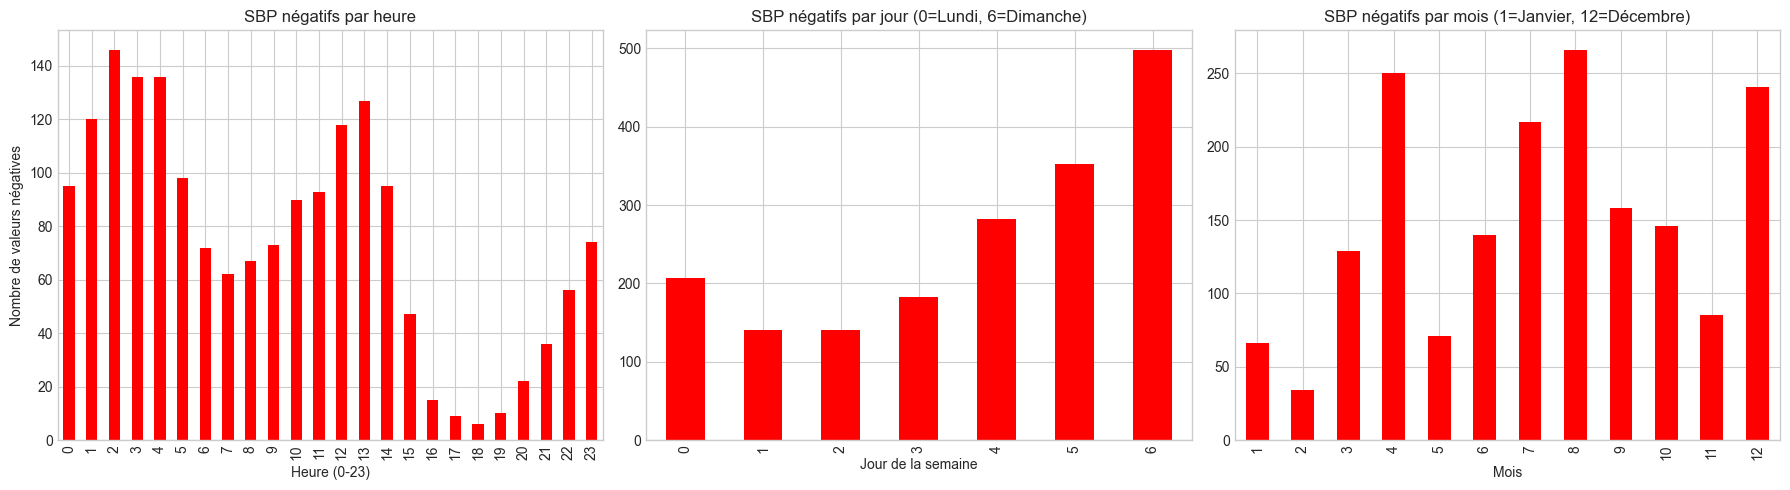

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1) Histogramme des valeurs négatives par heure
df_neg["hour"].value_counts().sort_index().plot(
    kind="bar", color="red", ax=axes[0]
)
axes[0].set_title("SBP négatifs par heure")
axes[0].set_xlabel("Heure (0-23)")
axes[0].set_ylabel("Nombre de valeurs négatives")

# 2) Histogramme des valeurs négatives par jour de la semaine
df_neg["dayofweek"].value_counts().sort_index().plot(
    kind="bar", color="red", ax=axes[1]
)
axes[1].set_title("SBP négatifs par jour (0=Lundi, 6=Dimanche)")
axes[1].set_xlabel("Jour de la semaine")
axes[1].set_ylabel("")

# 3) Histogramme des valeurs négatives par mois
df_neg["month"].value_counts().sort_index().plot(
    kind="bar", color="red", ax=axes[2]
)
axes[2].set_title("SBP négatifs par mois (1=Janvier, 12=Décembre)")
axes[2].set_xlabel("Mois")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()

**Analyse consolidée des SBP négatifs par heure, jour et mois :**

- **Par heure** : On constate un pic de valeurs négatives la nuit (environ 0–4 h) et en fin de soirée (22–23 h).  
  &nbsp;&nbsp;&rarr; **Interprétation** : Durant ces plages horaires, la demande est beaucoup plus faible, créant un surplus d’énergie et donc un prix potentiellement sous zéro.

- **Par jour de la semaine** : Le week-end, surtout le dimanche (jour 6), présente le plus de SBP négatifs.  
  &nbsp;&nbsp;&rarr; **Interprétation** : La consommation industrielle/commerciale chute généralement le dimanche, favorisant un excès d’offre et une baisse de prix.

- **Par mois** : Certains mois (en hiver ou en été) enregistrent davantage de SBP négatifs, tandis que d’autres en ont moins.  
  &nbsp;&nbsp;&rarr; **Interprétation** : Il s’agit probablement d’une **saisonnalité** liée à la production renouvelable (vent/soleil) et aux variations de la demande (chauffage, climatisation).  

Dans l’ensemble, ces graphiques soulignent que les **SBP négatifs** se produisent régulièrement, principalement lors de **faible demande** ou d’**excès d’offre** (nuit, dimanche, saison creuse), confirmant un phénomène de marché réel plutôt qu’une anomaie isolée.


# 6. Feature Engineering <a name="feature-engineering"></a>

Dans cette section, nous ajoutons ou transformons des variables (ex. colonnes temporelles, éventuel shift+log de SBP, etc.)

In [24]:
def apply_sbp_transform(df: pd.DataFrame, shift_log: bool = False, offset: float = None) -> (pd.DataFrame, str):
    """
    Si shift_log=True, applique un offset pour gérer SBP négatif, puis log.
    Crée deux colonnes:
      - SBP_shift = SBP + offset
      - SBP_log   = log(SBP_shift)
    Retourne (df_modifie, nom_col_target).
    """
    if shift_log:
        # Calcul automatique de l'offset si pas fourni
        if offset is None:
            sbp_min = df["SBP"].min()
            offset = abs(sbp_min) + 1  # ex: ~186.33 si min = -185.33

        df["SBP_shift"] = df["SBP"] + offset
        df["SBP_log"] = np.log(df["SBP_shift"])
        target_col = "SBP_log"
        print(f"[Info] shift+log transform with offset={offset:.2f} => target = {target_col}")
    else:
        target_col = "SBP"  # SBP brut
        print("[Info] Using SBP as target (raw scale).")

    return df, target_col

In [32]:
df, target_col = apply_sbp_transform(df, shift_log=True)

[Info] shift+log transform with offset=186.33 => target = SBP_log


# 7. Séparation Train/Test et Pipeline de Modélisation <a name="séparation-traintest-et-pipeline-de-modélisation"></a>

Ici, nous faisons un split temporel:
1. Train: 2023-02-15 à 2024-12-31
2. Test: 2025-01-01 à 2025-02-15
3. Ensuite, nous construisons une fonction pipeline final (`final_pipeline`).

In [26]:
def split_train_test(df: pd.DataFrame, train_start: str, train_end: str, test_start: str, test_end: str) -> (pd.DataFrame, pd.DataFrame):
    """
    Effectue un split temporel sur df.index (DatetimeIndex).
    Retourne (df_train, df_test).
    """
    df_train = df.loc[train_start:train_end].copy()
    df_test  = df.loc[test_start:test_end].copy()
    print(f"[Info] Train range: {train_start} to {train_end}, {len(df_train)} rows.")
    print(f"[Info] Test range:  {test_start} to {test_end}, {len(df_test)} rows.")
    return df_train, df_test

In [33]:
df_train, df_test = split_train_test(df, "2023-02-15", "2024-12-31", "2025-01-01", "2025-02-15")

[Info] Train range: 2023-02-15 to 2024-12-31, 31868 rows.
[Info] Test range:  2025-01-01 to 2025-02-15, 2059 rows.


# 8. Entraînement du Modèle <a name="entraînement-du-modèle"></a>

In [28]:
def train_xgboost(X_train, y_train) -> xgb.XGBRegressor:
    """
    Entraîne un XGBoostRegressor avec quelques hyperparamètres basiques.
    """
    model = xgb.XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.05,
        random_state=42
    )
    model.fit(X_train, y_train)
    return model

In [34]:
features = ["TSDF","NDF","INDDEM","IMBALNGC","hour","dayofweek","month","reserveScarcityPrice"]
X_train = df_train[features]
y_train = df_train[target_col]

X_test = df_test[features]
y_test = df_test[target_col]
model = train_xgboost(X_train, y_train)

# 9. Évaluation du Modèle <a name="évaluation-du-modèle"></a>

In [30]:
def evaluate_model(model, X_train, y_train, X_test, y_test,
                   shift_log: bool = False, offset: float = None):
    """
    Evalue le modèle (train et test) en calculant RMSE, MAE, R².
    Gère l'inverse log si shift_log=True.
    """
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    if shift_log:
        # On repasse en échelle SBP brute
        # SBP_pred = exp(SBP_log_pred) - offset
        y_pred_train_original = np.exp(y_pred_train) - offset
        y_pred_test_original  = np.exp(y_pred_test)  - offset

        y_train_original = np.exp(y_train) - offset
        y_test_original  = np.exp(y_test)  - offset

        rmse_train = (mean_squared_error(y_train_original, y_pred_train_original))**0.5
        rmse_test  = (mean_squared_error(y_test_original,  y_pred_test_original))**0.5

        mae_train  = mean_absolute_error(y_train_original, y_pred_train_original)
        mae_test   = mean_absolute_error(y_test_original,  y_pred_test_original)

        r2_train   = r2_score(y_train, y_pred_train)
        r2_test    = r2_score(y_test,  y_pred_test)

        print(f"[Eval] SHIFT+LOG scenario (offset={offset:.2f})")
        print(f"  Train RMSE: {rmse_train:.2f}, Test RMSE: {rmse_test:.2f}")
        print(f"  Train MAE:  {mae_train:.2f},  Test MAE:  {mae_test:.2f}")
        print(f"  Train R²:   {r2_train:.2f},   Test R²:   {r2_test:.2f}")

    else:
        # Échelle brute
        rmse_train = (mean_squared_error(y_train, y_pred_train))**0.5
        rmse_test  = (mean_squared_error(y_test,  y_pred_test))**0.5

        mae_train  = mean_absolute_error(y_train, y_pred_train)
        mae_test   = mean_absolute_error(y_test,  y_pred_test)

        r2_train   = r2_score(y_train, y_pred_train)
        r2_test    = r2_score(y_test,  y_pred_test)

        print("[Eval] Using SBP raw scale.")
        print(f"  Train RMSE: {rmse_train:.2f}, Test RMSE: {rmse_test:.2f}")
        print(f"  Train MAE:  {mae_train:.2f},  Test MAE:  {mae_test:.2f}")
        print(f"  Train R²:   {r2_train:.2f},   Test R²:   {r2_test:.2f}")

In [35]:
# On récupère l’offset depuis la fonction apply_sbp_transform si on l’a calculé
offset = abs(df["SBP"].min()) + 1  # ou la valeur que vous aviez calculée

evaluate_model(model, X_train, y_train, X_test, y_test, shift_log=True, offset=offset)

[Eval] SHIFT+LOG scenario (offset=186.33)
  Train RMSE: 35.81, Test RMSE: 187.53
  Train MAE:  28.33,  Test MAE:  49.30
  Train R²:   0.49,   Test R²:   0.01


# 10. Conclusion et Pistes d'Amélioration <a name="conclusion-et-pistes-damélioration"></a>